In [4]:
import numpy as np
from scipy.optimize import minimize
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from Euler_1stOrderForward import getEulerBOLD
from scipy import signal

In [12]:
num_sims = 1
csds_arr = []
f = None
for i in range(num_sims):
    print(i)
    _, bold = getEulerBOLD(2, alpha=1, beta=1, noise=True, length=1000)
    f, csd = signal.csd(bold, bold, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096)
    csd_mag = np.sqrt(csd.real ** 2 + csd.imag ** 2)
    csds_arr.append(csd_mag)

csds = np.array(csds_arr)


0
tensor([-0.7823, -0.7694, -0.7619,  ..., -0.8020, -0.7904, -0.7924])
[ 0.          0.          0.         ... -1.13506186 -1.13492787
 -1.13479376]


[0. 0. 0. ... 0. 0. 0.]


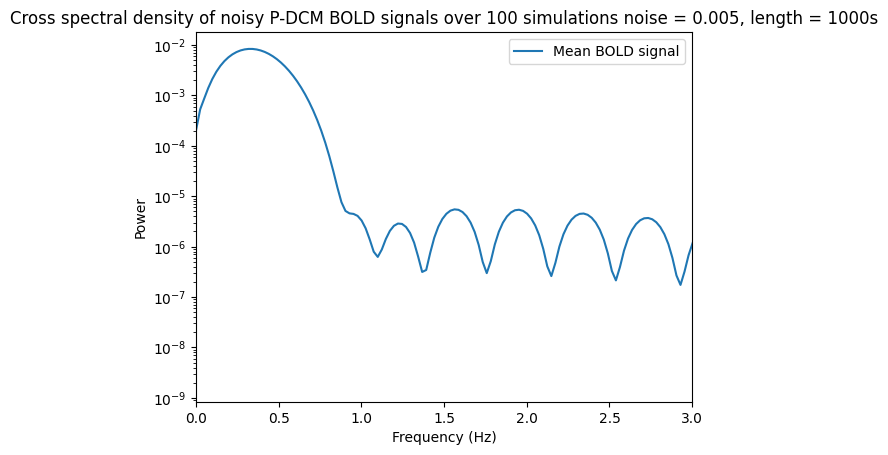

In [15]:


# Calculate mean and standard deviation
mean_signal = np.nanmean(csds, axis=0)
std_deviation = np.nanstd(csds, axis=0)

print(std_deviation)
#take logs here?
plt.xlim(0, 3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Cross spectral density of noisy P-DCM BOLD signals over 100 simulations noise = 0.005, length = 1000s')
plt.semilogy(f, mean_signal, label='Mean BOLD signal')
plt.legend()
plt.fill_between(f, mean_signal-std_deviation, mean_signal+std_deviation, facecolor = 'lightblue', label='standard deviation')
plt.show()


In [8]:
def mse_loss(predicted_signal, observed_signal):
    # Calculate the mean squared error as the loss using CSD???
    # f, csdx = signal.csd(predicted_signal, predicted_signal, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096)
    # f, csdy = signal.csd(observed_signal, observed_signal, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096)
    
    mse_real = np.mean(np.abs(np.real(predicted_signal) - np.real(observed_signal))**2)
    mse_imaginary = np.mean(np.abs(np.imag(predicted_signal) - np.imag(observed_signal))**2)
    
    # Combine the losses for real and imaginary parts
    loss = mse_real + mse_imaginary
    print(loss)
    return loss

In [24]:
def cmae(y_true, y_pred):
    # Compute absolute differences for real and imaginary parts
    abs_diff_real = np.abs(np.real(y_true) - np.real(y_pred))
    abs_diff_imag = np.abs(np.imag(y_true) - np.imag(y_pred))
    
    # Compute mean absolute error
    cmae = np.mean(abs_diff_real + abs_diff_imag)
    
    return cmae

In [ ]:
def plot_csds(f, csdx, csdy):
    plt.xlim(0, 1)
    plt.plot(f, csdx, label="predicted")
    plt.plot(f, csdy, label="observed")
    plt.legend()
    plt.show()

In [10]:
#fix alpha, change beta
# simulated signal -> alpha and beta 1 -> calculate csd
observed_bold = np.loadtxt('./time_series/sub-001-PLCB-ROI0.txt', delimiter=',')
_, observed_csd = signal.csd(observed_bold, observed_bold, fs=0.5, noverlap=None,  window='hamming', scaling='density')
all_losses = []
betas = np.arange(0.5, 3.5, 0.1)
mtts = np.arange(1, 3, 0.1)
num_sims = 25

for i in range(num_sims):
    print(i)
    losses = []
    for mtt in mtts:
        _, bold = getEulerBOLD(mtt, 1, 1, True, 1000)
        f, csd = signal.csd(bold, bold, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096)
        # plot_csds(f, csdx, csdy)
        loss = mse_loss(csd, observed_csd)
        losses.append(loss)
    all_losses.append(losses)

all_losses = np.array(all_losses)

mean_loss = np.nanmean(all_losses, axis=0)
std_deviation_loss = np.nanstd(all_losses, axis=0)

plt.xlabel('MTT value')
plt.ylabel('Loss')
plt.title('Mean loss curve over 100 simulations')
plt.plot(mtts, mean_loss, label='Mean loss')
plt.legend()
plt.fill_between(mtts, mean_loss-std_deviation_loss, mean_loss+std_deviation_loss, facecolor = 'lightblue', label='standard deviation')
plt.show()


/Users/adhithikedlaya/rl/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  warnings.warn('nperseg = {0:d} is greater than input length '


0


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

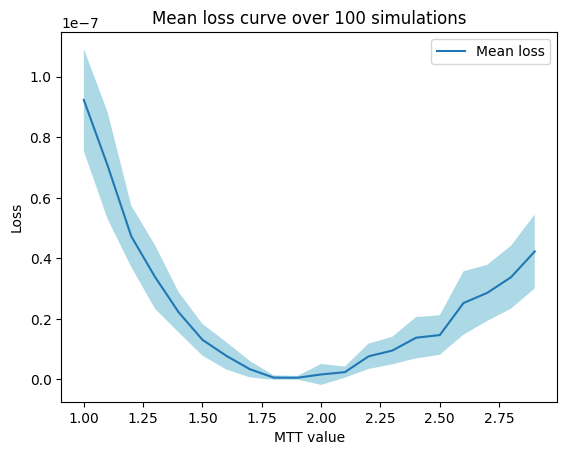

In [9]:
# all_losses = np.array(all_losses)

# mean_loss = np.nanmean(all_losses, axis=0)
# std_deviation_loss = np.nanstd(all_losses, axis=0)

plt.xlabel('MTT value')
plt.ylabel('Loss')
plt.title('Mean loss curve over 100 simulations')
plt.plot(mtts, mean_loss, label='Mean loss')
plt.legend()
plt.fill_between(mtts, mean_loss-std_deviation_loss, mean_loss+std_deviation_loss, facecolor = 'lightblue', label='standard deviation')
plt.show()

/var/folders/l8/v51s8fxx7b34r635gds96p7c0000gn/T/ipykernel_23146/1013022346.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/var/folders/l8/v51s8fxx7b34r635gds96p7c0000gn/T/ipykernel_23146/1013022346.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


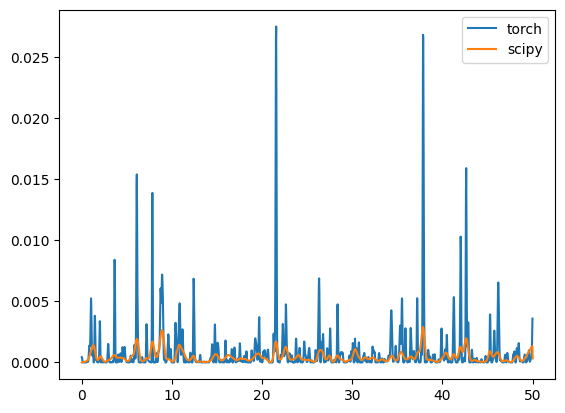

In [5]:
import torch
import torch.fft
from scipy import signal
import matplotlib.pyplot as plt

def csd_pytorch(x, y, fs=1.0, nperseg=None, noverlap=None, nfft=4096, return_onesided=True, window='hamming', scaling='density'):
    # Convert inputs to torch tensors
    x = torch.tensor(x)
    y = torch.tensor(y)

    # Calculate the length of the segments for the spectrogram
    if nperseg is None:
        nperseg = min(len(x), len(y))
    else:
        nperseg = min(nperseg, len(x), len(y))

    # Calculate overlap length
    if noverlap is None:
        noverlap = nperseg // 2

    # Calculate the number of segments
    nstep = nperseg - noverlap
    num_segments = (len(x) - noverlap) // nstep

    # Calculate the FFT length
    if nfft is None:
        nfft = max(256, 2 ** int(torch.log2(torch.tensor(nperseg).float())))

    # Select window function
    if window == 'hann':
        window_fn = torch.hann_window(nperseg)
    elif window == 'hamming':
        window_fn = torch.hamming_window(nperseg)
    else:
        raise ValueError("Unsupported window type. Choose 'hann' or 'hamming'.")

    # Compute the scaling factor
    if scaling == 'density':
        scale = 2 / (fs * torch.sum(window_fn ** 2))
    elif scaling == 'spectrum':
        scale = 1 / (fs * torch.sum(window_fn))
    else:
        raise ValueError("Unsupported scaling type. Choose 'density' or 'spectrum'.")

    # Apply windowing
    x_windowed = x.unfold(0, nperseg, nstep) * window_fn
    y_windowed = y.unfold(0, nperseg, nstep) * window_fn

    # Compute the FFT of the windowed signals
    X = torch.fft.fft(x_windowed, n=nfft)
    Y = torch.fft.fft(y_windowed, n=nfft)

    # Compute the cross spectral density
    Pxy = (X * torch.conj(Y)).mean(dim=0) * scale

    # Calculate the frequency axis
    f = torch.fft.fftfreq(nfft, 1.0 / fs)

    # Return the result
    if return_onesided:
        return f[:nfft//2], Pxy[:nfft//2]
    else:
        return f, Pxy

# Example usage
x = torch.randn(1000)
y = torch.randn(1000)
fs = 100  # Sample rate

frequencies, csd_values = csd_pytorch(x, x, fs=fs)
f, csd = signal.csd(x, x, fs=100, noverlap=None,  window='hamming', scaling='density', nfft=4096)
plt.plot(frequencies, csd_values.real ** 2 + csd_values.imag ** 2, label='torch')
plt.plot(f, csd.real ** 2 + csd.imag ** 2, label='scipy')
plt.legend()
plt.show()





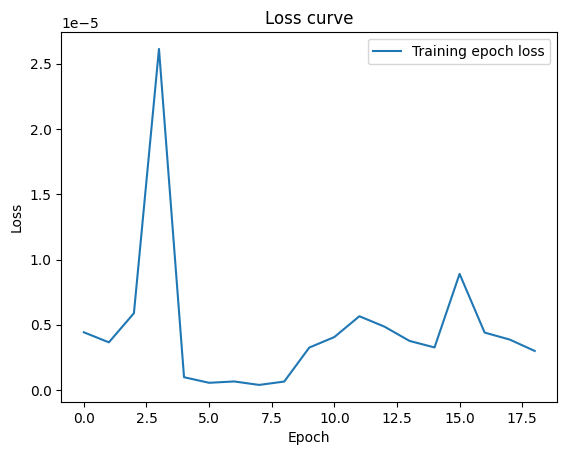

In [19]:
import json


# Read JSON file
with open('losses.json', 'r') as json_file:
    losses = json.load(json_file)


epochs = np.arange(len(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.plot(epochs, losses, label='Training epoch loss')
plt.legend()
plt.show()
